# BagiData Data Scientist Test
## News Title Classification
Submitted by Nikko P. Gunara

February 25th, 2022.

## Importing Libraries and Dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
import joblib
tqdm.pandas()
import re
import string
from autocorrect import Speller

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [42]:
df = pd.read_excel('News Title.xls', index_col='No')
titles = df['News Title']
labels = df['Category']
df.head()

,News Title,Category
No,,
1,Google+ rolls out 'Stories' for tricked out ph...,Technology
2,Dov Charney's Redeeming Quality,Business
3,White God adds Un Certain Regard to the Palm Dog,Entertainment
4,"Google shows off Androids for wearables, cars,...",Technology
5,China May new bank loans at 870.8 bln yuan,Business


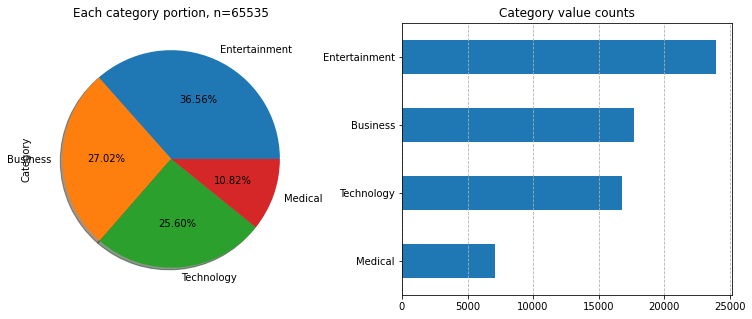

In [3]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
labels.value_counts().plot(kind='pie', autopct='%.2f%%', shadow=True, ax=ax[0])
ax[0].set_title(f'Each category portion, n={len(df)}')
labels.value_counts().sort_values().plot(kind='barh', ax=ax[1])
ax[1].set_title('Category value counts')
ax[1].xaxis.grid(linestyle='--')

The graphs above show that the dataset has 65k+ news title data with 4 categories, ranked from the most to the least are Entertainment (36.56%), Business (27.02%), Technology (25.60%), and Medical (10.82%). These findings of the imbalanced dataset may be critical for further analysis or decision in the next phase of the classification process.

## Preprocessing

Lowering all text and performing standard text cleaning procedure cited from: 
https://github.com/kk7nc/Text_Classification#id9

The procedure includes:
1. Removing unnecessary spaces.
2. Removing unnecessary characters.
3. Removing numbers. (addition)
4. Removing URL links. (addition)

In [43]:
titles = titles.progress_apply(lambda x: x.lower())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [00:00<00:00, 624054.89it/s]


In [44]:
def clean_text(text):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'\s*<br\s*/?>\s*': u'\n'},  # newline after a <br>
        {r'</(div)\s*>\s*': u'\n'},  # newline after </p> and </div> and <h1/>...
        {r'</(p|h\d)\s*>\s*': u'\n\n'},  # newline after </p> and </div> and <h1/>...
        {r'<head>.*<\s*(/head|body)[^>]*>': u''},  # remove <head> to </head>
        {r'<a\s+href="([^"]+)"[^>]*>.*</a>': r'\1'},  # show links instead of texts
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''},  # remove spaces at the beginning
        {r'[0-9]+': ''}, # remove numbers
        {r'(http\S+|\S+.com|\S+.net)': ''} # removing url link
    ]
    for rule in rules:
        for k, v in rule.items():
            regex = re.compile(k)
            text = regex.sub(v, str(text))
            text = text.strip()
            text = text.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations
    return text

titles = titles.progress_apply(lambda title: clean_text(title))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [00:06<00:00, 9811.46it/s]


Tokenizing text; splitting titles/sentences to list of word tokens.

In [45]:
titles = titles.progress_apply(lambda title: word_tokenize(title))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [00:08<00:00, 7362.48it/s]


Stopwords removal; removing unnecessary words (stopwords), that might not be relevant for classification. Since the dataset are in English, stopwords from Natural Language Tool Kit (nltk) library is used.
(https://www.nltk.org/)

In [46]:
stopwords_ = set(stopwords.words('english'))
titles = titles.progress_apply(lambda title: [w for w in title if not w in stopwords_])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [00:00<00:00, 174274.14it/s]


Autocorrection is an optional pre-processing step. But it's common to find text or documents data sets that contain typos or misspellings. To reduce the possibility of these errors affecting the classification, this step is conducted.

In [48]:
spell = Speller(lang='en')
titles = titles.progress_apply(lambda title: [spell(w) for w in title])

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [59:18<00:00, 18.42it/s]


The final step of the preprocessing is lemmatization. It's been known that a word may appear in different forms, so this lemmatization process is conducted to replaces the suffix of a word and returns the basic word form (lemma).

In [49]:
lemmatizer = WordNetLemmatizer()
titles = titles.progress_apply(lambda title: [lemmatizer.lemmatize(w) for w in title])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 65535/65535 [00:04<00:00, 14151.61it/s]


Due to the long process of autocorrecting each word from 65k+ news titles (could take up to 60mins), we created a checkpoint save file to load if you want to save time.

In [50]:
filename = "newstitle-cleaned-checkpoint.pkl"

# saving preprocessed dataset to file
titles.to_pickle(filename)

# load saved file (uncomment below code to load from file)
# titles = pd.read_pickle(filename)

At this phase, we have a preprocessed news titles dataset and ready to be extracted. But before that, we could visualize a WordCloud of each category. WordCloud is commonly used to see most frequent word of each category. 

65535it [00:00, 111192.26it/s]


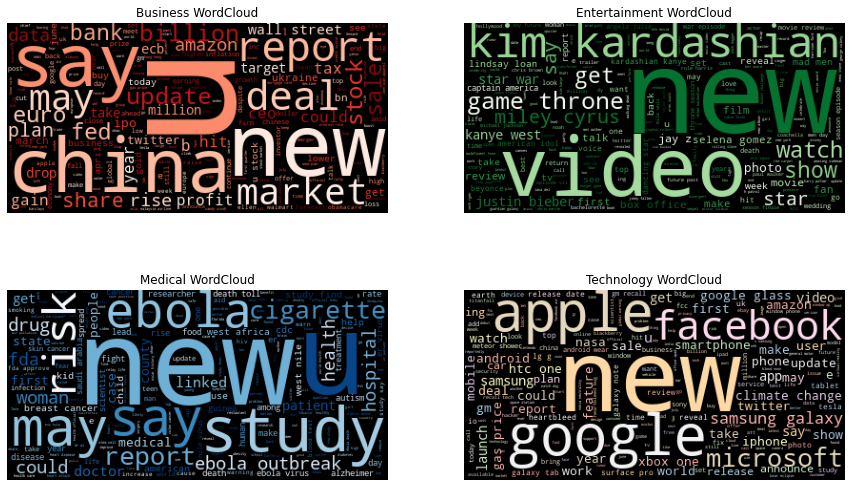

In [51]:
businessText = ''
entertainmentText = ''
medicalText = ''
techText = ''

for title, label in tqdm(zip(titles, labels)):
    if label=='Business':
        for word in title:
            businessText += ' ' + word
    elif label=='Entertainment':
        for word in title:
            entertainmentText += ' ' + word
    elif label=='Medical':
        for word in title:
            medicalText += ' ' + word
    elif label=='Technology':
        for word in title:
            techText += ' ' + word

businessWC = WordCloud(background_color='black',
                min_font_size=3, colormap='Reds',
                stopwords=stopwords_).generate(businessText)
entertainmentWC = WordCloud(background_color='black',
                min_font_size=3, colormap='Greens',
                stopwords=stopwords_).generate(entertainmentText)
medicalWC = WordCloud(background_color='black',
                min_font_size=3, colormap='Blues',
                stopwords=stopwords_).generate(medicalText)
techWC = WordCloud(background_color='black',
                min_font_size=3, colormap='Pastel1',
                stopwords=stopwords_).generate(techText)

fig, ax = plt.subplots(2,2, figsize=(15,9))
ax[0][0].set_title('Business WordCloud')
ax[0][0].imshow(businessWC)
ax[0][0].axis('off')
ax[0][1].set_title('Entertainment WordCloud')
ax[0][1].imshow(entertainmentWC)
ax[0][1].axis('off')
ax[1][0].set_title('Medical WordCloud')
ax[1][0].imshow(medicalWC)
ax[1][0].axis('off')
ax[1][1].set_title('Technology WordCloud')
ax[1][1].imshow(techWC)
ax[1][1].axis('off')
plt.show()

## Feature Extraction

There are various feature extraction methods in NLP, from Weighted Words to Deep Learning-based models. Each method has advantages and disadvantages. For this news title classification case, a common Word Embedding method known as Word2Vec is used. This method is known for the advantage that provides a very powerful tool for discovering relationships in the text corpus as well as similarities between words (Kowsari et al., 2019).

Gensim library even provides the pre-trained word embedding models with various corpus or data sets. For this specific news title case, we can leverage the use of word2vec-google-news-300 pretrained model for feature extraction, since this model was trained using Google News including about 100 billion words.

Refs:
1. https://github.com/RaRe-Technologies/gensim-data
2. Kowsari, K., Jafari Meimandi, K., Heidarysafa, M., Mendu, S., Barnes, L., & Brown, D. (2019). Text classification algorithms: A survey. Information, 10(4), 150.


In [ ]:
w2v_google_news = api.load('word2vec-google-news-300')

In [ ]:
fname = "word2vec-google-news-300.bin"

# saving downloaded word embedding model to local file
# w2v_google_news.save(fname)

# load saved file (uncomment below code to load from file)
w2v_google_news = KeyedVectors.load(fname)

Here, the model is built to extract a vector of each word with 300 dimensions. Since the dataset is a news title with more than 1-word tokens, to extract each title data, the average of the feature vectors of multiple word tokens is used as a feature for 1 title data.

In [ ]:
def wv_func(word):
    try:
        return w2v_google_news[word]
    except:
        return [float(0) for i in range(300)]

vecs = titles.progress_apply(lambda title: np.array([wv_func(w) for w in title]).mean(axis=0))

In [ ]:
vecsDF = pd.DataFrame.from_dict(dict(zip(vecs.index, vecs.values))).T
vecsDF['labels'] = labels
vecsDF = vecsDF.dropna()
vecsDF.reset_index(drop=True, inplace=True)
vecsDF.head()

Here, another checkpoint is created. At this point, the preprocessed dataset have been extracted using pre-trained Word2Vec and saved in vecsDF dataframe. This data is then ready to be processed further to classification.

In [12]:
filename = "newstitle-extracted-checkpoint.pkl"

# saving ready-to-use vector dataframe to file
# vecsDF.to_pickle(filename)

# load saved file
vecsDF = pd.read_pickle(filename)

## Dimensionality Reduction

Word2Vec extracts feature vector with 300 dimensions. This high dimension feature may also affect the training or model development time, and even classification performance. One of a widely dimensionality reduction method used is Principal Component Analysis (PCA). The "elbow method" is commonly used to choose the appropriate number of components for PCA. But in this case, n_components is tuned in the hyperparameter optimization process. Here, we visualize the data points of each news title category in the first 3 PC feature space.

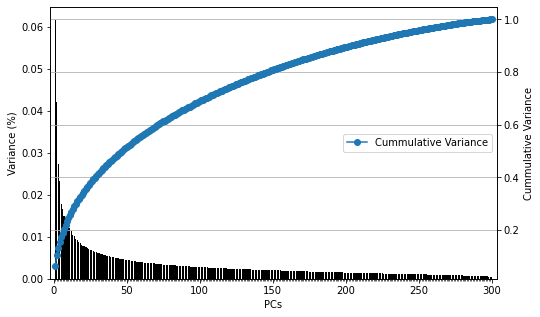

In [52]:
ss = StandardScaler()
Xstd = ss.fit_transform(vecsDF.iloc[:,:-1])

pca = PCA()
Xpca = pca.fit_transform(Xstd)

features = range(1, pca.n_components_+1)
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(features, pca.explained_variance_ratio_, color='black', label='Variance (%)')
ax1.set_xlabel('PCs')
ax1.set_ylabel('Variance (%)')
ax1.set_xticks([i+1 for i in range(len(pca.explained_variance_))], minor=True)
ax1.margins(x=0.01)

ax2 = ax1.twinx()
ax2.plot([i+1 for i in range(len(pca.explained_variance_ratio_))], np.cumsum(pca.explained_variance_ratio_), '-o', label='Cummulative Variance')
ax2.set_ylabel('Cummulative Variance')
plt.grid()
plt.legend(loc=7)
plt.show()

In [53]:
dfPCA = pd.DataFrame(Xpca)
dfPCA['labels'] = vecsDF.labels
dfPCA.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,labels
0,3.718809,-0.084186,7.292089,0.403343,-2.658299,1.465437,2.823549,1.406900,0.501994,2.004460,...,-0.350085,-0.500204,-0.844658,-0.194273,0.238518,0.116736,0.365318,0.291288,-0.413164,Technology
1,-3.507581,0.860945,3.415822,-1.318206,-0.696778,-1.411349,-0.590378,-2.951055,-1.259930,-0.918931,...,-0.397093,-0.454084,0.727978,-0.003029,0.027261,-0.389126,-0.452771,0.702592,-0.504097,Business
2,-0.323014,-1.530065,1.585560,1.745801,1.966542,0.909874,-1.852918,-2.765490,2.754261,0.999993,...,0.358515,-0.597929,0.075196,-0.421018,0.348602,-0.000923,-0.824723,0.309429,-0.020218,Entertainment
3,7.760775,2.525378,8.129333,2.524661,0.179707,3.326598,2.659024,1.158913,1.047101,1.170960,...,-0.264434,-0.062242,-0.094317,0.002389,-0.144289,0.270118,-0.262379,-0.324251,-0.201406,Technology
4,-3.611746,7.391969,-4.291270,-1.578177,0.769424,-0.544804,3.843576,-0.859192,2.680265,1.496019,...,-0.451850,-0.285969,0.280322,-0.016795,-0.255400,-0.214745,-0.253893,0.452776,0.408944,Business


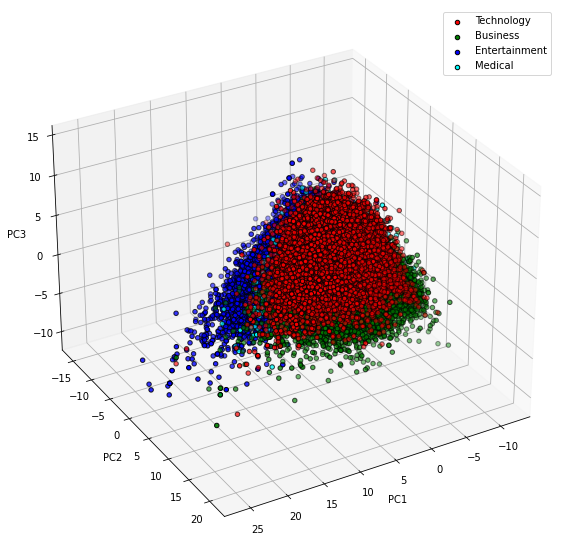

In [54]:
pcx = 'PC1'
pcy = 'PC2'
pcz = 'PC3'
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['red', 'green', 'blue', 'cyan']

for color, label in zip(colors, dfPCA.labels.unique()):
    ax.scatter3D(dfPCA[dfPCA['labels']==label][0], dfPCA[dfPCA['labels']==label][1], dfPCA[dfPCA['labels']==label][2], color=color, marker='o', edgecolors='k', label=label)

ax.set_xlabel(pcx)
ax.set_ylabel(pcy)
ax.set_zlabel(pcz)
ax.view_init(elev=30., azim=60.) # rotate view angle
plt.legend()
plt.show()

## Train and Tune Models

On models:

In this classification phase, we compare some of the models that are commonly used in the development of text classification such as Random Forest, Extreme Gradient Boosting, and k-Nearest Neighbors. 

On hyperparameter optimization:

Each of these models' hyperparameters is then tuned using Bayesian Optimization from Scikit-Optimize (skopt) library. The main hyperparameters to be tuned of each model are chosen by reference to (Yang & Shami, 2020).

On cross-validation:

Cross-validation in this phase is done by using Stratified k-Fold. The use of stratified cross-validation is due to the imbalance of the dataset. By using the stratified cross-validation, the split portion of each fold is done by considering the portion of each category.


Refs:
1. https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
2. Yang, L., & Shami, A. (2020). On hyperparameter optimization of machine learning algorithms: Theory and practice. Neurocomputing, 415, 295-316.

In [14]:
X = vecsDF.iloc[:,:-1]
y = vecsDF.labels

x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=23)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

### Random Forest Classifier

In [ ]:
pipeRFC = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', RandomForestClassifier(n_jobs=4))
])

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

In [ ]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,50,50, dtype=int)),
    'clf__n_estimators': list(np.linspace(10,50,41, dtype=int)),
    'clf__max_depth': list(np.linspace(5,50,46, dtype=int)),
    'clf__min_samples_split': list(np.linspace(1,50,50, dtype=int)),
    'clf__min_samples_leaf': list(np.linspace(1,50,50, dtype=int)),
    'clf__criterion': ['gini', 'entropy']
}

bsRFC = BayesSearchCV(
    pipeRFC,
    parameter_grid,
    scoring='f1_macro',
    verbose=10,
    n_jobs=4,
    cv=skf,
    n_iter=30,
    random_state=12
)

print("[INFO]: Tuning started.")
bsRFC.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsRFC.best_params_.keys(), bsRFC.best_params_.values()):
    print(f'{k}\t: {v}')

In [6]:
model_filename = 'newstitle-bayes-rfc.pkl'

# save best estimator to disk
# joblib.dump(bsRFC.best_estimator_, model_filename)

# load saved model from disk
bsRFC = joblib.load(model_filename)

[INFO]: Classification Reports:
               precision    recall  f1-score   support

     Business       0.77      0.78      0.78      3541
Entertainment       0.82      0.92      0.86      4792
      Medical       0.86      0.65      0.74      1418
   Technology       0.80      0.74      0.77      3355

     accuracy                           0.81     13106
    macro avg       0.81      0.77      0.79     13106
 weighted avg       0.81      0.81      0.80     13106



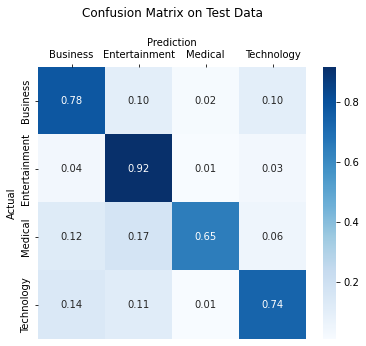

In [56]:
y_pred = bsRFC.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
plt.show()

### XGBoost

In [ ]:
pipeXGB = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', XGBClassifier(n_jobs=4,
                          eval_metric='mlogloss',
                          use_label_encoder=False))
])

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

In [ ]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,50,50, dtype=int)),
    'clf__n_estimators': list(np.linspace(10,50,41, dtype=int)),
    'clf__max_depth': list(np.linspace(5,50,46, dtype=int)),
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

bsXGB = BayesSearchCV(
    pipeXGB,
    parameter_grid,
    scoring='f1_macro',
    verbose=10,
    cv=skf,
    n_iter=30,
    random_state=22
)

print("[INFO]: Tuning started.")
bsXGB.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsXGB.best_params_.keys(), bsXGB.best_params_.values()):
    print(f'{k}\t: {v}')

In [5]:
model_filename = 'newstitle-bayes-xgb.pkl'

# save best estimator to disk
# joblib.dump(bsXGB.best_estimator_, model_filename)

# load saved model from disk
bsXGB = joblib.load(model_filename)

[INFO]: Classification Reports:
               precision    recall  f1-score   support

     Business       0.80      0.80      0.80      3541
Entertainment       0.85      0.93      0.89      4792
      Medical       0.86      0.72      0.78      1418
   Technology       0.83      0.78      0.80      3355

     accuracy                           0.83     13106
    macro avg       0.84      0.81      0.82     13106
 weighted avg       0.83      0.83      0.83     13106



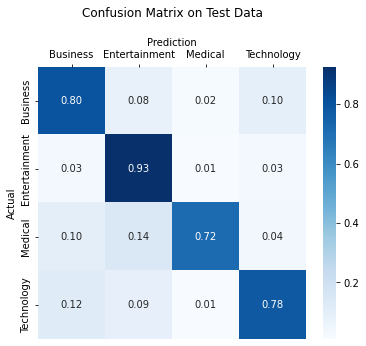

In [55]:
y_pred = bsXGB.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
plt.show()

### k-Nearest Neighbors

In [28]:
pipeKNN = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('clf', KNeighborsClassifier(algorithm='kd_tree')) # using kd_tree because memory error
])

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

In [29]:
parameter_grid = {
    'pca__n_components': list(np.linspace(1,50,50, dtype=int)),
    'clf__n_neighbors': list(np.linspace(1,20,20, dtype=int))
}

bsKNN = BayesSearchCV(
    pipeKNN,
    parameter_grid,
    scoring='f1_macro',
    verbose=10,
    n_jobs=4,
    cv=skf,
    n_iter=30
)

print("[INFO]: Tuning started.")
bsKNN.fit(x_train, y_train)
print("[INFO]: Done.")
print(f"\nBEST PARAMETERS: ")
for k,v in zip(bsKNN.best_params_.keys(), bsKNN.best_params_.values()):
    print(f'{k}\t: {v}')

[INFO]: Tuning started.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [33]:
model_filename = 'newstitle-bayes-knn.pkl'

# save best estimator to disk
# joblib.dump(bsKNN.best_estimator_, model_filename)

# load saved model from disk
bsKNN = joblib.load(model_filename)

[INFO]: Classification Reports:
               precision    recall  f1-score   support

     Business       0.82      0.86      0.84      3541
Entertainment       0.87      0.95      0.91      4792
      Medical       0.90      0.76      0.82      1418
   Technology       0.89      0.79      0.83      3355

     accuracy                           0.86     13106
    macro avg       0.87      0.84      0.85     13106
 weighted avg       0.86      0.86      0.86     13106



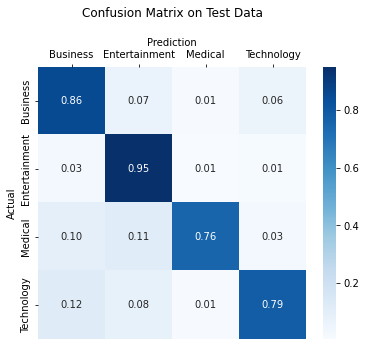

In [31]:
y_pred = bsKNN.predict(x_test)
print("[INFO]: Classification Reports:")
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
plt.show()

## Evaluation

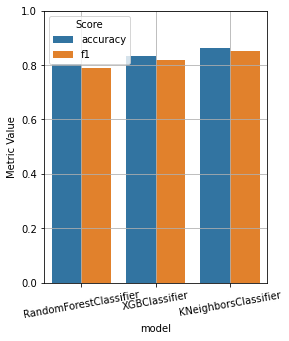

In [36]:
accuracies, f1s, models = list(), list(), list()

for model in [bsRFC, bsXGB, bsKNN]:
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracies.append(acc)
    f1s.append(f1)
    models.append(str(model.steps[2][1]).split('(')[0])

df_plot = pd.DataFrame(zip(accuracies, f1s, models), columns=['accuracy', 'f1', 'model'])
df_melt = pd.melt(df_plot, id_vars='model', var_name='Score', value_name='Metric Value')
fig, ax = plt.subplots(figsize=(4,5))
g = sns.barplot(x='model', y='Metric Value', hue='Score', data=df_melt, ax=ax)
g.set(ylim=(0, 1))
plt.xticks(rotation=10)
plt.grid()
plt.show()

Amongst the models used, KNN shows the best performance on the test data with the highest F1 score and accuracy of up to 0.85 and 0.86, respectively.  The test data consists of 20% of the dataset with an amount of 13k+ data.

### Test Model with News Titles picked from Google

In [ ]:
def preprocess_text(titles):
    titles = pd.Series(titles)
    titles = titles.apply(lambda x: x.lower())
    titles = titles.apply(lambda title: clean_text(title))
    titles = titles.apply(lambda title: word_tokenize(title))
    titles = titles.apply(lambda title: [w for w in title if not w in stopwords_])
    titles = titles.apply(lambda title: [spell(w) for w in title])
    titles = titles.apply(lambda title: [lemmatizer.lemmatize(w) for w in title])
    vector = titles.apply(lambda title: np.array([wv_func(w) for w in title]).mean(axis=0))
    return vector

In [ ]:
# https://economictimes.indiatimes.com/markets/stocks/news/adani-wilmar-shares-tank-8-ahead-of-q3-results-m-cap-slips-below-rs-50000-crore/articleshow/89558160.cms
businessTitle = "Adani Wilmar shares tank 8% ahead of Q3 results; m-cap slips below Rs 50,000 crore" 
# https://www.dailymail.co.uk/tvshowbiz/article-10541029/Kim-Kardashian-pays-tribute-late-father-Robert-Kardashian-78th-birthday.html
entertainmentTitle = "Kim Kardashian pays tribute to late father Robert Kardashian on what would have been his 78th birthday with throwback snap from 1998: 'I feel you all the time'"
# https://www.upi.com/Health_News/2022/02/22/COVID-19-vaccine-children-MIS-C-study/9021645557340/
medicalTitle = "Study: Heart complication after COVID-19 vaccination rare in teens, young adults"
# https://analyticsindiamag.com/metaverse-drives-ar-vr-headset-shipments-to-hit-14-mn-units-in-2022/
techTitle = "Thanks to metaverse, AR/VR headset shipments to hit 14 Mn units in 2022"

vector = preprocess_text(techTitle)
prediction = bsKNN.predict(vector.values[0].reshape(1,-1))
print(f"Prediction: {le.inverse_transform(prediction)}")